## Analysis of News stories coveraging UK Rwanda Asylum

In [1]:
import pandas as pd
import glob 
from nltk.sentiment import vader
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
%matplotlib inline

In [2]:
import glob
import os

file_list = glob.glob(os.path.join(os.getcwd(), "C:/Users/Saidi/Downloads/step2 (1)/articles", "*.txt"))

corpus = []

for file_path in file_list:
    with open(file_path) as f_input:
        corpus.append(f_input.read())

print(corpus)

['UK government plans to send some asylum seekers to Rwanda are being challenged in court.\nThe government says the measures would reduce numbers crossing the English Channel, but critics question Rwanda\'s human rights record.\nWhat is the Rwanda asylum plan?\nThe five-year trial will see some asylum seekers who arrive in the UK sent to Rwanda on a one-way ticket, to claim asylum there.\nThey may be granted refugee status to stay in Rwanda. If not, they can apply to settle there on other grounds, or seek asylum in a "safe third country".\nThe government says it will deter people arriving in the UK through "illegal, dangerous or unnecessary methods", such as on small boats which cross the English Channel.\nHowever, the numbers crossing have not fallen since the policy was announced on 14 April. More than 33,500 people have already used this route to come to the UK this year, the highest figure since records began.\n Chart showing number of migrants who have crossed channel in year to d

In [3]:
#file_list = glob.glob(os.path.join(os.getcwd(), "FolderName", "*.txt"))
#file_list = glob.glob(os.path.join(os.getcwd(), "C:/Users/Saidi/Downloads/step2 (1)/articles", "*.txt"))
#corpus2 = [open(file).read() for file in file_list]
#print(corpus2)

In [4]:
df = pd.DataFrame(corpus, columns=['articles'])
df=df.drop_duplicates()
df

,articles
0,UK government plans to send some asylum seeker...
1,ï»¿How the UK's Rwanda plan mirrors immigratio...
2,ï»¿Rwanda calls for UK deportation scheme to b...
3,ï»¿Truss pledges to expand Rwanda scheme to ot...
4,ï»¿'Nobody knew about it': How the UK's 'world...
5,ï»¿'No clear evidence' plan to send migrants t...
7,ï»¿Rwanda asylum seekers: UK could send first ...
8,ï»¿UK-Rwanda asylum seekers' deal: Good news f...
9,ï»¿UK asylum deal: Is Rwanda a land of safety ...
10,ï»¿Rwanda asylum plan: UK ministers partially ...


### Extract sentences from the articles 

In [5]:
# Get the individual sentences from every article 
sentences = df['articles'].str.split(".").apply(pd.Series).reset_index()
sentences = sentences.melt(id_vars=['index'], var_name='sentence', value_name='text')

# Drop rows with missings
sentences.dropna(inplace=True)
sentences = sentences[sentences['text']!='']
sentences.reset_index(inplace=True, drop=True)

In [6]:
sentences.head()

,index,sentence,text
0,0,0,UK government plans to send some asylum seeker...
1,1,0,ï»¿How the UK's Rwanda plan mirrors immigratio...
2,2,0,ï»¿Rwanda calls for UK deportation scheme to b...
3,3,0,ï»¿Truss pledges to expand Rwanda scheme to ot...
4,4,0,ï»¿'Nobody knew about it': How the UK's 'world...


###  Clean text

In [7]:
 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


sentences['cleanText']=sentences['text'].map(lambda s:preprocess(s)) 

In [8]:
sentences 

,index,sentence,text,cleanText
0,0,0,UK government plans to send some asylum seeker...,government plans send asylum seekers rwanda ch...
1,1,0,ï»¿How the UK's Rwanda plan mirrors immigratio...,rwanda plan mirrors immigration policies austr...
2,2,0,ï»¿Rwanda calls for UK deportation scheme to b...,rwanda calls deportation scheme given chance p...
3,3,0,ï»¿Truss pledges to expand Rwanda scheme to ot...,truss pledges expand rwanda scheme countries s...
4,4,0,ï»¿'Nobody knew about it': How the UK's 'world...,nobody knew world first migration deal gone rw...
...,...,...,...,...
410,1,73,"By pursuing forced expulsions, the UK is know...",pursuing forced expulsions knowingly causing m...
411,1,74,"\n""MSF has witnessed such suffering on Nauru i...",msf witnessed suffering nauru island australia...
412,1,75,"There, 65% of our refugee and asylum seeker p...",refugee asylum seeker patients felt control ev...
413,1,76,These patients were significantly more likely...,patients significantly likely suicidal diagnos...


In [9]:
sentences=sentences.drop(['text'],axis=1)
sentences 

,index,sentence,cleanText
0,0,0,government plans send asylum seekers rwanda ch...
1,1,0,rwanda plan mirrors immigration policies austr...
2,2,0,rwanda calls deportation scheme given chance p...
3,3,0,truss pledges expand rwanda scheme countries s...
4,4,0,nobody knew world first migration deal gone rw...
...,...,...,...
410,1,73,pursuing forced expulsions knowingly causing m...
411,1,74,msf witnessed suffering nauru island australia...
412,1,75,refugee asylum seeker patients felt control ev...
413,1,76,patients significantly likely suicidal diagnos...


## Top 8 words used in UK media 

In [10]:
text = sentences.iloc[:,2] # extract column with text
import numpy as np
 

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

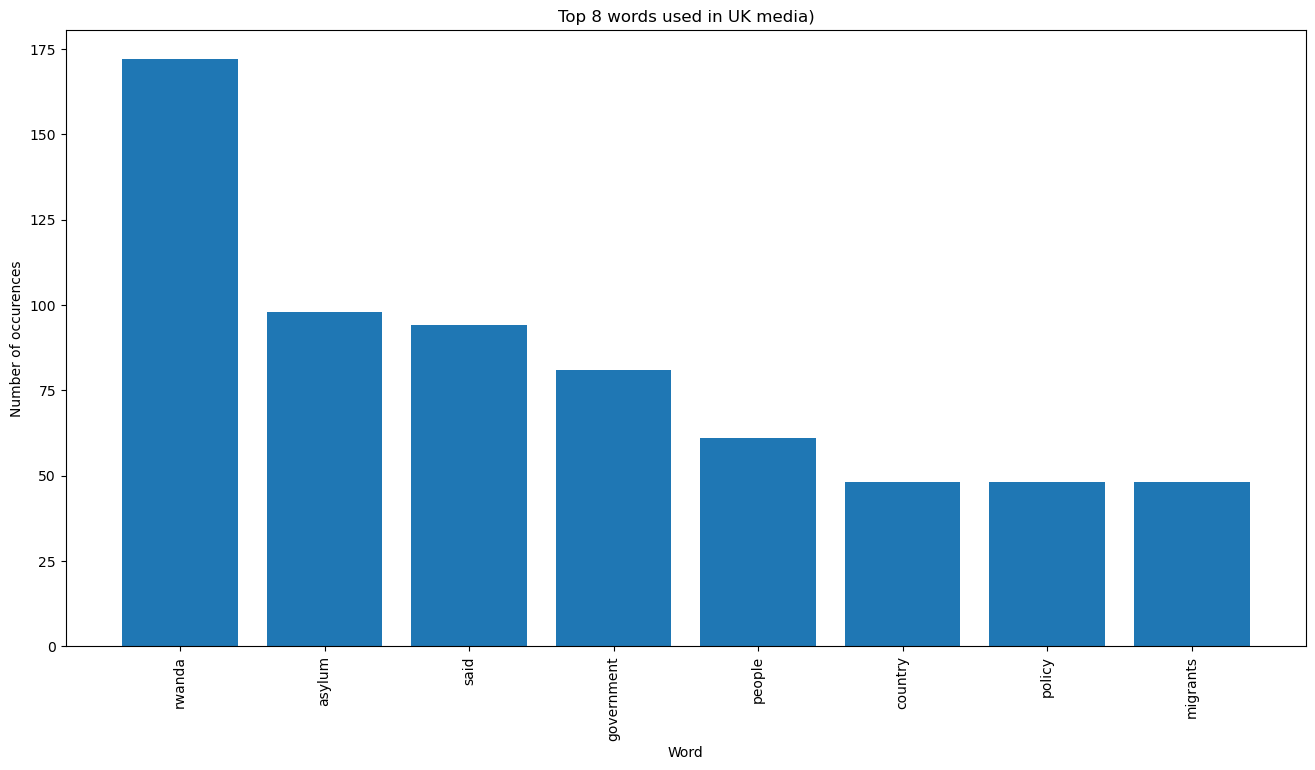

In [11]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=8,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=text)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 8 words used in UK media)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Check if sentence mentions asylum or mingrants, rwanda and Policy

In [12]:
sentences['asyl'] = sentences['cleanText'].str.count('[aA]syl*')
sentences['migrants'] = sentences['cleanText'].str.count('migrants*')
sentences['rwanda'] = sentences['cleanText'].str.count('rwanda*')
sentences['policy'] = sentences['cleanText'].str.count('policy*')
sentences

,index,sentence,cleanText,asyl,migrants,rwanda,policy
0,0,0,government plans send asylum seekers rwanda ch...,1,0,1,0
1,1,0,rwanda plan mirrors immigration policies austr...,0,0,2,1
2,2,0,rwanda calls deportation scheme given chance p...,0,0,1,1
3,3,0,truss pledges expand rwanda scheme countries s...,0,0,1,0
4,4,0,nobody knew world first migration deal gone rw...,0,0,2,0
...,...,...,...,...,...,...,...
410,1,73,pursuing forced expulsions knowingly causing m...,0,0,0,0
411,1,74,msf witnessed suffering nauru island australia...,0,0,0,1
412,1,75,refugee asylum seeker patients felt control ev...,1,0,0,0
413,1,76,patients significantly likely suicidal diagnos...,0,0,0,0


### Sentiment 

In [13]:
# Run vader
classifier= vader.SentimentIntensityAnalyzer()
sentences['sentiment']=sentences['cleanText'].map(classifier.polarity_scores)
sentences['sentiment'] = sentences['sentiment'].apply(lambda x: x['compound'])
sentences['classfication'] = sentences['sentiment'].apply(lambda c: 'positive' if c>0
                                                            else 'negative')

sentences 

,index,sentence,cleanText,asyl,migrants,rwanda,policy,sentiment,classfication
0,0,0,government plans send asylum seekers rwanda ch...,1,0,1,0,-0.1027,negative
1,1,0,rwanda plan mirrors immigration policies austr...,0,0,2,1,0.0000,negative
2,2,0,rwanda calls deportation scheme given chance p...,0,0,1,1,0.3818,positive
3,3,0,truss pledges expand rwanda scheme countries s...,0,0,1,0,0.8591,positive
4,4,0,nobody knew world first migration deal gone rw...,0,0,2,0,0.6003,positive
...,...,...,...,...,...,...,...,...,...
410,1,73,pursuing forced expulsions knowingly causing m...,0,0,0,0,-0.8442,negative
411,1,74,msf witnessed suffering nauru island australia...,0,0,0,1,-0.7269,negative
412,1,75,refugee asylum seeker patients felt control ev...,1,0,0,0,0.0000,negative
413,1,76,patients significantly likely suicidal diagnos...,0,0,0,0,-0.6705,negative


C:\Anaconda3.2\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Anaconda3.2\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='asyl', ylabel='sentiment'>

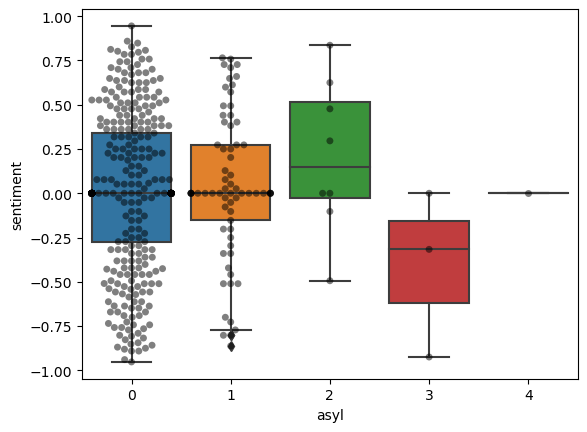

In [14]:
import seaborn as sns
sns.boxplot(x=sentences["asyl"], y=sentences["sentiment"])
sns.swarmplot(x='asyl', y='sentiment', data=sentences, color='black', alpha=0.5)

<AxesSubplot:ylabel='classfication'>

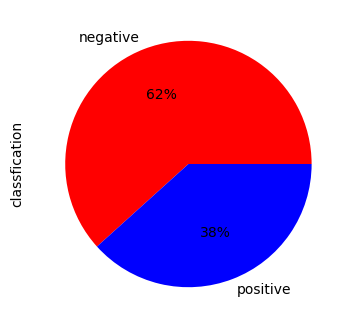

In [15]:
 sentences.classfication.value_counts().plot(kind='pie', autopct='%1.0f%%',
                                   figsize=(4,4),colors=["red", "blue"])

<AxesSubplot:xlabel='rwanda', ylabel='asyl'>

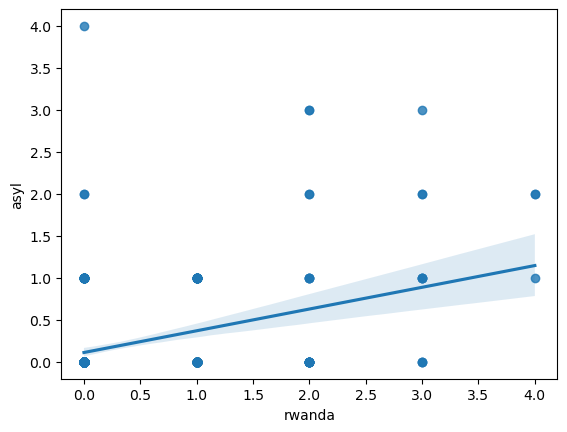

In [16]:
#Is there a relationship between migration talk and rwanda?
sns.regplot(x=sentences["rwanda"], y=sentences["asyl"]) 

<AxesSubplot:xlabel='rwanda', ylabel='sentiment'>

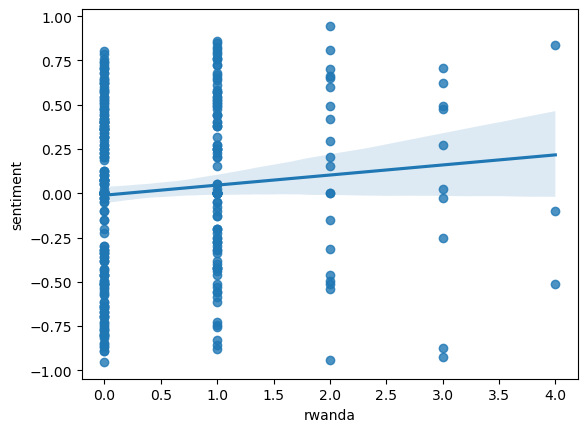

In [17]:
sns.regplot(x=sentences["rwanda"], y=sentences["sentiment"]) 

In [18]:
#!pip install pyppeteer
#!pip install nbconvert

In [1]:
#!pip install tinytext

In [2]:
from tinytext import tinytext